# Stock exchange prediction

## Data preparation

This code will unzip the data archive into data folder

In [1]:
import shutil
import zipfile
import os
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import DBNInference
from pgmpy.estimators import MaximumLikelihoodEstimator
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import glob
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dirs_to_remove = ['data/ETFs', 'data/Stocks']
for d in dirs_to_remove:
    if os.path.exists(d):
        shutil.rmtree(d)

with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [ ]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
i = 0
df_all = pd.DataFrame()
for file in glob.glob("data/Stocks/*.txt"):
    try:
        df = pd.read_csv(file, sep=',')
    except Exception:
        continue
    df = df[pd.to_numeric(df[num_cols].stack(), errors='coerce').notna().unstack().all(axis=1)]
    enterprise = file[12:-7]
    df["Enterprise"] = enterprise
    df_all = pd.concat([df_all, df])
    i += 1
    if i == 20:
        break

df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.drop(columns=['OpenInt'], inplace=True)
df_all.sort_values(by=['Enterprise', 'Date'], inplace=True)

In [3]:
df_all

Date     Open     High      Low    Close   Volume Enterprise
0   2005-02-25  12.1800  12.3600  12.0300  12.1300   480600        cbg
1   2005-02-28  12.1500  12.1500  11.9900  12.0300   569400        cbg
2   2005-03-01  12.0000  12.1300  11.9500  12.0700  1119900        cbg
3   2005-03-02  12.0700  12.3000  12.0200  12.1700   462000        cbg
4   2005-03-03  12.2000  12.2300  11.8200  12.1700   660600        cbg
..         ...      ...      ...      ...      ...      ...        ...
803 2017-11-06  25.4854  25.4900  25.4710  25.4815     3328       wbii
804 2017-11-07  25.4600  25.4732  25.4600  25.4600    38173       wbii
805 2017-11-08  25.4800  25.4900  25.4310  25.4664     8262       wbii
806 2017-11-09  25.3968  25.4100  25.3600  25.3950    12744       wbii
807 2017-11-10  25.3500  25.3500  25.2684  25.2750     6782       wbii

[32375 rows x 7 columns]

In [3]:
train_lagged = []
test_lagged = []

df_all_cp = df_all.copy()
df_all_cp[num_cols] = df_all_cp.groupby("Enterprise")[num_cols].pct_change()
df_all_cp.dropna(inplace=True)
df_all_cp.replace([np.inf, -np.inf], 100, inplace=True)

for name, group in df_all_cp.groupby('Enterprise'):
    group = group.reset_index(drop=True)

    # df_data_pct_change = df[num_cols].pct_change()
    # df_data_pct_change = df_data_pct_change.iloc[1:].reset_index(drop=True)

    # df_all[num_cols] = df_all.groupby('Enterprise')[num_cols].pct_change()
    # print(df_all)
    # df_all.dropna(inplace=True)
    # print(df_all.isnull().sum())

    # Skip if not enough data
    if len(group) < 3:
        continue

    # Discretize numeric features per enterprise
    group_disc = group.copy()
    # group_disc[num_cols] = group_disc[num_cols].pct_change()
    # group_disc.dropna(inplace=True)

    # if len(group_disc) < 4:
    #     continue
    # for col in num_cols:
    #     group_disc[col] = pd.qcut(group[col], q=3, labels=False, duplicates='drop')

    # Split into 80% train, 20% test
    split_idx = int(0.8 * len(group_disc))

    # Make sure we keep t and t+1 pairs
    train_seq = group_disc.iloc[:split_idx + 1]
    test_seq = group_disc.iloc[split_idx:]

    disc_train = pd.DataFrame()
    disc_test = pd.DataFrame()
    for col in group_disc.columns:
        if col in num_cols:
            train_col, bin_edges = pd.qcut(train_seq[col], q=3, labels=False, retbins=True, duplicates='drop')
            test_col = pd.cut(test_seq[col], bins=bin_edges, labels=False, include_lowest=True)
            disc_train[col] = train_col
            disc_test[col] = test_col.fillna(method='ffill').fillna(method='bfill')
        else:
            disc_train[col] = train_seq[col]
            disc_test[col] = test_seq[col]
    

    # Lagging train data
    t0_train = disc_train.iloc[:-1].reset_index(drop=True)
    t1_train = disc_train.iloc[1:].reset_index(drop=True)
    t0_train.columns = [(col, 0) if col != 'Enterprise' else 'Enterprise' for col in t0_train.columns]
    t1_train.columns = [(col, 1) if col != 'Enterprise' else 'Enterprise' for col in t1_train.columns]
    train_merged = pd.concat([t0_train, t1_train], axis=1)
    
    # Remove duplicate 'Enterprise' columns if present
    if train_merged.columns.duplicated().any():
        train_merged = train_merged.loc[:, ~train_merged.columns.duplicated()]
    train_merged = train_merged[train_merged['Enterprise'] == train_merged['Enterprise']]
    train_merged.drop(columns='Enterprise', inplace=True)
    train_lagged.append(train_merged)

    # Lagging test data
    if len(disc_test) >= 2:
        t0_test = disc_test.iloc[:-1].reset_index(drop=True)
        t1_test = disc_test.iloc[1:].reset_index(drop=True)
        t0_test.columns = [(col, 0) if col != 'Enterprise' else 'Enterprise' for col in t0_test.columns]
        t1_test.columns = [(col, 1) if col != 'Enterprise' else 'Enterprise' for col in t1_test.columns]
        test_merged = pd.concat([t0_test, t1_test], axis=1)
        if test_merged.columns.duplicated().any():
            test_merged = test_merged.loc[:, ~test_merged.columns.duplicated()]
        test_merged = test_merged[test_merged['Enterprise'] == test_merged['Enterprise']]
        test_merged.drop(columns='Enterprise', inplace=True)
        test_lagged.append(test_merged)

final_train_df = pd.concat(train_lagged, ignore_index=True)
final_test_df = pd.concat(test_lagged, ignore_index=True)


/tmp/ipykernel_10838/3973825269.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  disc_test[col] = test_col.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_10838/3973825269.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  disc_test[col] = test_col.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_10838/3973825269.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  disc_test[col] = test_col.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_10838/3973825269.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  disc_test[col] = test_col.fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_1

In [5]:
display(final_train_df)

(Date, 0)  (Open, 0)  (High, 0)  (Low, 0)  (Close, 0)  (Volume, 0)  \
0     2005-02-28          1          0         1           0            2   
1     2005-03-01          0          1         1           1            2   
2     2005-03-02          1          2         1           1            0   
3     2005-03-03          2          1         0           1            2   
4     2005-03-04          1          2         2           2            2   
...          ...        ...        ...       ...         ...          ...   
25873 2017-03-17          0          2         0           1            1   
25874 2017-03-20          2          1         2           1            1   
25875 2017-03-21          1          1         1           1            1   
25876 2017-03-22          1          1         1           1            1   
25877 2017-03-23          1          2         1           2            1   

       (Date, 1)  (Open, 1)  (High, 1)  (Low, 1)  (Close, 1)  (Volume, 1)  
0     2005-03-01          0          1         1           1            2  
1     2005-03-02          1          2         1           1            0  
2     2005-03-03          2          1         0           1            2  
3     2005-03-04          1          2         2           2            2  
4     2005-03-07          2          2         1           1            0  
...          ...        ...        ...       ...         ...          ...  
25873 2017-03-20          2          1         2           1            1  
25874 2017-03-21          1          1         1           1            1  
25875 2017-03-22          1          1         1           1            1  
25876 2017-03-23          1          2         1           2            1  
25877 2017-03-24          1          1         1           1            1  

[25878 rows x 12 columns]

In [4]:
print(final_train_df[("Close", 0)].value_counts())
print(final_test_df[("Close", 1)].value_counts())

(Close, 0)
0    8643
2    8637
1    8598
Name: count, dtype: int64
(Close, 1)
1.0    2742
2.0    1882
0.0    1833
Name: count, dtype: int64


In [5]:
final_train_df = final_train_df.drop(columns=[('Date', 0), ('Date', 1)])
final_test_df = final_test_df.drop(columns=[('Date', 0), ('Date', 1)])

In [12]:
dbn = DBN()

dbn.add_edges_from([
    (('Open', 0), ('Close', 0)),
    (('High', 0), ('Close', 0)),
    (('Low', 0), ('Close', 0)),
    (('Volume', 0), ('Close', 0)),
])

# Inter-slice edges (temporal dependencies)
dbn.add_edges_from([
    (('Close', 0), ('Close', 1)),
    (('Open', 0), ('Open', 1)),
    (('High', 0), ('High', 1)),
    (('Low', 0), ('Low', 1)),
    (('Volume', 0), ('Volume', 1)),
    (('Open', 0), ('Close', 1)),
    (('High', 0), ('Close', 1)),
    (('Low', 0), ('Close', 1)),
    (('Volume', 0), ('Close', 1)),
])

In [13]:
dbn.fit(final_train_df, estimator="MLE")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'High_0': 'N', 'Close_0': 'N', 'Volume_0': 'N', 'Low_0': 'N', 'Open_0': 'N', 'High_1': 'N', 'Close_1': 'N', 'Volume_1': 'N', 'Low_1': 'N', 'Open_1': 'N'}


In [14]:
print(dbn.get_parents(('Close', 1)))

[<DynamicNode(Open, 1) at 0x7a610296c710>, <DynamicNode(High, 1) at 0x7a61028160c0>, <DynamicNode(Low, 1) at 0x7a6102816a20>, <DynamicNode(Volume, 1) at 0x7a6102102630>, <DynamicNode(Close, 0) at 0x7a61021037d0>, <DynamicNode(Open, 0) at 0x7a6102102180>, <DynamicNode(High, 0) at 0x7a6102100c80>, <DynamicNode(Low, 0) at 0x7a6102102360>, <DynamicNode(Volume, 0) at 0x7a6102101d00>]


## Test model

In [15]:
dbn_inf = DBNInference(dbn)
predictions = []
ground_truth = []

for i in range(len(final_test_df)):
    evidence = {col: final_test_df.iloc[i][col] for col in final_test_df.columns if isinstance(col, tuple) and col[1] == 0}
    print(evidence)
    true_val = final_test_df.iloc[i][("Close", 1)]
    
    query = dbn_inf.query(variables=[('Close', 1)], evidence=evidence)
    print(query[('Close', 1)])
    
    predicted = query[('Close', 1)].values.argmax()
    # print(query[('Close', 1)].values)
    # print(predicted)
    # print(true_val)
    predictions.append(predicted)
    ground_truth.append(true_val)

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:797: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


{('Open', 0): np.float64(1.0), ('High', 0): np.float64(1.0), ('Low', 0): np.float64(1.0), ('Close', 0): np.float64(1.0), ('Volume', 0): np.float64(0.0)}
+-----------------+---------------------+
| ('Close', 1)    |   phi(('Close', 1)) |
+=================+=====================+
| ('Close', 1)(0) |              0.3008 |
+-----------------+---------------------+
| ('Close', 1)(1) |              0.3555 |
+-----------------+---------------------+
| ('Close', 1)(2) |              0.3437 |
+-----------------+---------------------+
{('Open', 0): np.float64(1.0), ('High', 0): np.float64(1.0), ('Low', 0): np.float64(1.0), ('Close', 0): np.float64(1.0), ('Volume', 0): np.float64(1.0)}
+-----------------+---------------------+
| ('Close', 1)    |   phi(('Close', 1)) |
+=================+=====================+
| ('Close', 1)(0) |              0.2949 |
+-----------------+---------------------+
| ('Close', 1)(1) |              0.3877 |
+-----------------+---------------------+
| ('Close', 1)(2) |   

In [16]:
print(classification_report(ground_truth, predictions, target_names=['Low', 'Medium', 'High'], labels=[0, 1, 2]))

              precision    recall  f1-score   support

         Low       0.29      0.33      0.31      1833
      Medium       0.46      0.37      0.41      2742
        High       0.31      0.36      0.33      1882

    accuracy                           0.36      6457
   macro avg       0.36      0.35      0.35      6457
weighted avg       0.37      0.36      0.36      6457



In [17]:
print(disc_train['Close'].value_counts())
print(disc_test['Close'].value_counts())

Close
2    216
0    215
1    215
Name: count, dtype: int64
Close
1    67
2    52
0    43
Name: count, dtype: int64


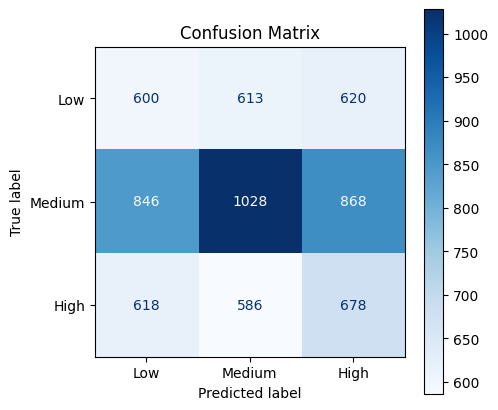

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Assuming ground_truth and predictions are already defined as in previous cells
cm = confusion_matrix(ground_truth, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [19]:
from scipy.stats import entropy

# Example: Compute entropy for the predicted class distribution in test_df_prepared
close_counts = final_test_df[('Close', 1)].value_counts().sort_index()
close_probs = close_counts / close_counts.sum()
ent = entropy(close_probs, base=2)
print(f"Entropy of ('Close', 1) in test_df_prepared: {ent:.4f}")

Entropy of ('Close', 1) in test_df_prepared: 1.5588


In [20]:
print("Intra-slice edges:", dbn.get_intra_edges())
print("Inter-slice edges:", dbn.get_inter_edges())

Intra-slice edges: [(<DynamicNode(Open, 0) at 0x7a6100fabda0>, <DynamicNode(Close, 0) at 0x7a6100fa9970>), (<DynamicNode(High, 0) at 0x7a6100fa8b30>, <DynamicNode(Close, 0) at 0x7a6100fa8c50>), (<DynamicNode(Low, 0) at 0x7a6100fa80b0>, <DynamicNode(Close, 0) at 0x7a6100fabec0>), (<DynamicNode(Volume, 0) at 0x7a6100fabc20>, <DynamicNode(Close, 0) at 0x7a6100fabe30>)]
Inter-slice edges: [(<DynamicNode(Open, 0) at 0x7a6102743170>, <DynamicNode(Open, 1) at 0x7a61023b1af0>), (<DynamicNode(Open, 0) at 0x7a6102743170>, <DynamicNode(Close, 1) at 0x7a6102102f00>), (<DynamicNode(Close, 0) at 0x7a610274db50>, <DynamicNode(Close, 1) at 0x7a6102100ce0>), (<DynamicNode(High, 0) at 0x7a6102816ed0>, <DynamicNode(High, 1) at 0x7a6102103650>), (<DynamicNode(High, 0) at 0x7a6102816ed0>, <DynamicNode(Close, 1) at 0x7a6102100ef0>), (<DynamicNode(Low, 0) at 0x7a6102815e20>, <DynamicNode(Low, 1) at 0x7a6102102f60>), (<DynamicNode(Low, 0) at 0x7a6102815e20>, <DynamicNode(Close, 1) at 0x7a61021010a0>), (<Dynam

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:797: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


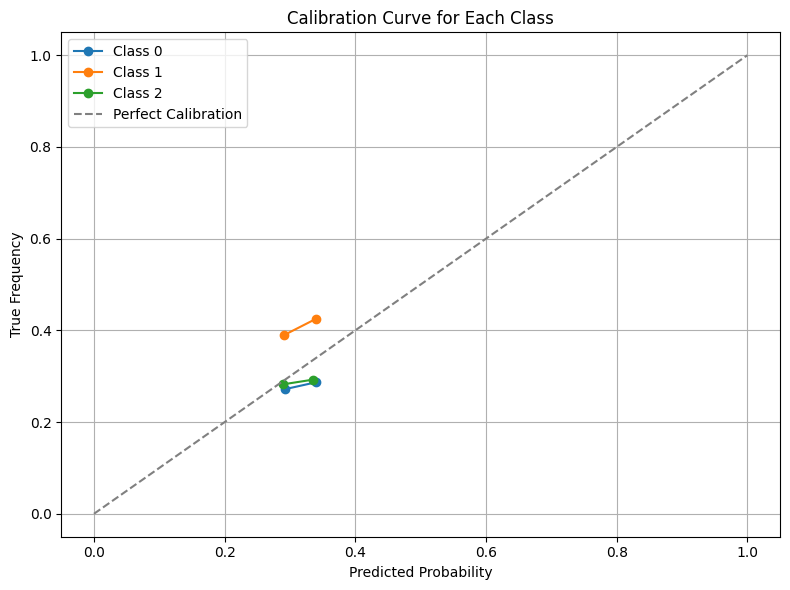

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

inference = DBNInference(dbn)

n_classes = 3
target_var = ('Close', 1)

true_labels = []
pred_probs = [[] for _ in range(n_classes)]

for idx, row in final_test_df.iterrows():
    evidence = {col: row[col] for col in final_test_df.columns if isinstance(col, tuple) and col[1] == 0}
    try:
        result = inference.query(variables=[target_var], evidence=evidence)
        probs = result[target_var].values
        true_label = int(row[target_var])
        true_labels.append(true_label)
        for c in range(n_classes):
            pred_probs[c].append(probs[c])
    except Exception as e:
        print(f"Error at index {idx}: {e}")

plt.figure(figsize=(8, 6))
for c in range(n_classes):
    y_true = [1 if label == c else 0 for label in true_labels]
    prob_true, prob_pred = calibration_curve(y_true, pred_probs[c], n_bins=10, strategy='uniform', pos_label=1)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {c}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Frequency')
plt.title('Calibration Curve for Each Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
